**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
            6) 활성
            7) 리텐션
        2. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import difflib

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

# 1.Data Import

In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
df_app_log = DataImport.read_files(
    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
    today = today + timedelta(days = 1), 
    dates = dates,
    platform_total = True, reduce_memory = True, verbose = False)
df_app_log_total = df_app_log.copy()

df_app_log_before = DataImport.set_date_range(df = df_app_log_total, start=datetime(2022,10,1), end = datetime(2022,10,17))
df_app_log_after = DataImport.set_date_range(df = df_app_log_total, start=datetime(2022,10,17), end = datetime(2022,11,3))
df_app_log = df_app_log_after.copy()

# 2.Preprocess

In [4]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) log
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)                # log data
df_app_log_total = SpherePrep.BasicPrep.basic_prep(df_app_log_total)                # log data

## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER], drop_none_prop=False)       # user data

## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [5]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
# df_param_install = DataImport.extract_event_param(df_param_all, EVENT_APP_INSTALL).drop_duplicates()
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter =\
     df_param_all[df_param_all[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

## 1)Utils

In [6]:
# cnt -> percent function
def cnt_to_percent_ver1(df, col):
    df[col] = df[col].astype(float)

    if  df.index.dtype != 'str':
        df.index = df.index.astype('str')
    
    _lst = []
    for i in range(0,len(df)):
        x = round((df[col][i] / df[col].sum())*100, 2)
        _lst.append(x)

    df['percent']= _lst
    return df

# 기기당 이벤트 수 ver1
def cal_event_cnt_per_device_ver1(df_target, dict_referrs, lst_event, text):
    dict_page_cnt = {}
    for key, values in dict_referrs.items():
        _df = df_target[df_target[KEY_ID_DEVICE].isin(values)]
        _series_event_cnt = _df['abs_events'].apply(lambda x : len(set(x) & set(lst_event))
                                if len(set(lst_event) & set(x)) > 0 else 0)
        _df['page_cnt'] = _series_event_cnt
        EVENT_CNT_PER_DEVICE = _df.groupby([KEY_ID_DEVICE, 'day'])['page_cnt'].count().mean()
        
        dict_page_cnt[f'{key}'] = _series_event_cnt
        print(f'{key}', text, round(EVENT_CNT_PER_DEVICE, 2), '회')

## 기기당 이벤트 수 ver2
def cal_event_cnt_per_device_ver2(df_target, text):
        df_target['event_cnt'] = df_target['abs_events'].apply(lambda x: len(x))
        EVENT_CNT_PER_DEVICE = df_target.groupby([KEY_ID_DEVICE, 'day'])['event_cnt'].count().mean()
        print(text, round(EVENT_CNT_PER_DEVICE, 2), '회')

# divide top/mid/low
def divide_high_mid_low(df, col_nm):
    _dict_group = dict()
    _dict_group['high'] = df[
        df[col_nm] >= df[col_nm].quantile(0.66)].index
    _dict_group['middle'] = df[
        (df[col_nm] < df[col_nm].quantile(0.66)) &
        (df[col_nm] >= df[col_nm].quantile(0.33))].index
    _dict_group['low'] = df[
        df[col_nm] < df[col_nm].quantile(0.33)].index
    
    return _dict_group

def get_daily_cnt(dict_output, lst, nm, dict_input, df_target = df_app_log, KEY_ID = KEY_ID_DEVICE, 
                  make_sub_dict = False):
    # 1. 전체 일별 수치
    df_daily = df_app_log[df_app_log[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_app_log[df_app_log[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        df_daily[f'{key}'] = _df[f'{key}_{nm}']
        df_daily.fillna(0, inplace=True)
        # pd.concat([df_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return df_daily

# 3.Analysis
## 0)Segment Setting

In [7]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
dict_lst_user_from_referrs_gudok['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_duration_per_device[df_duration_per_device < 5].index)
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
## gender
dict_seg_gender = dict()
dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

## age
dict_seg_age = dict()
# dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# ======================================================== #  next version
dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

In [8]:
## prep: instagram => INSTA, kakao_mo &kakaotalk_bizmessage => KAKAO_moment
dict_lst_user_from_referrs_gudok['KAKAO_moment'] =\
    list(
        set(
            dict_lst_user_from_referrs_gudok['kakao_mo'] +\
            dict_lst_user_from_referrs_gudok['KAKAO_moment'] +\
            dict_lst_user_from_referrs_gudok['kakaotalk_bizmessage']
            )
        )
dict_lst_user_from_referrs_gudok['FB_INSTA'] =\
    list(    
        set(
            dict_lst_user_from_referrs_gudok['instagram'] +\
            dict_lst_user_from_referrs_gudok['FB_INSTA'] +\
            dict_lst_user_from_referrs_gudok['Facebook']
            )
    )

del dict_lst_user_from_referrs_gudok['kakaotalk_bizmessage']
del dict_lst_user_from_referrs_gudok['kakao_mo']
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['Facebook']

dict_lst_user_from_referrs_gudok.keys()

dict_keys(['GDN', 'FB_INSTA', 'NAVER_GFA', 'KAKAO_moment', 'organic'])

## 1)매체 성과 분석
### (1)유입
- 전체 유입
- 신규/기존 유입

In [ ]:
#########################################
# 1. 매체별 전체 유입인원
#########################################
dict_output_inflow_cnt = {}

for key, values in dict_lst_user_from_referrs_gudok.items():
    dict_output_inflow_cnt[f'{key}'] = {}
    dict_output_inflow_cnt[f'{key}']['inflow_cnt'] = len(set(values))

df_total_inflow_referrs = pd.DataFrame.from_dict(dict_output_inflow_cnt, orient='index', columns=['inflow_cnt'])
df_total_inflow_referrs = cnt_to_percent_ver1(df_total_inflow_referrs, 'inflow_cnt')
df_total_inflow_referrs.sort_values(by = 'inflow_cnt', ascending=False)


# SphereVis.basic_bar_plot(
#     df_total_inflow_referrs, x = df_total_inflow_referrs.index, y = 'percent', title= '가볼래-터 매체별 전체 유입인원')
# plt.show()

,inflow_cnt,percent
organic,2117384.0,97.92
KAKAO_moment,12629.0,0.58
GDN,12394.0,0.57
NAVER_GFA,11473.0,0.53
FB_INSTA,8390.0,0.39
Facebook,1.0,0.00


In [31]:
#########################################
# 2. 일별 유입
# 전체 / 신규 / 기존
#########################################
for _lst, key in zip(
    [list(df_app_log[KEY_ID_DEVICE].unique()),
     lst_new_device,lst_re_device],
    ['inflow', 'new_inflow', 're_inflow']
    ) :
    _df_daily_inflow = get_daily_cnt(
        dict_output_inflow_cnt, 
        lst=_lst, nm=key, 
        dict_input = dict_lst_user_from_referrs_gudok)
    _df_daily_inflow

,total_inflow,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,Facebook,organic
day,,,,,,,
2022-10-01,118057,4,64,2.0,12,0.0,117596
2022-10-02,104588,4,46,2.0,14,0.0,104197
2022-10-03,75489,6,31,2.0,9,0.0,75090
2022-10-04,71652,5,50,4.0,13,0.0,71204
2022-10-05,69234,2,180,7.0,5,0.0,68616
2022-10-06,59372,2,55,0.0,13,0.0,58907
2022-10-07,85988,6,59,3.0,19,0.0,85287
2022-10-08,136494,6,37,3.0,24,0.0,135947
2022-10-09,76787,8,23,4.0,16,0.0,76338


,total_inflow,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,Facebook,organic
day,,,,,,,
2022-10-01,93390,2.0,16,1.0,7,0.0,93143
2022-10-02,84323,2.0,9,0.0,6,0.0,84123
2022-10-03,61396,0.0,6,1.0,6,0.0,61215
2022-10-04,57900,2.0,10,2.0,9,0.0,57665
2022-10-05,55991,1.0,36,3.0,1,0.0,55641
2022-10-06,46043,0.0,11,0.0,7,0.0,45771
2022-10-07,69361,4.0,12,0.0,8,0.0,68960
2022-10-08,115574,3.0,14,0.0,14,0.0,115220
2022-10-09,61881,3.0,9,0.0,7,0.0,61598


,total_inflow,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,Facebook,organic
day,,,,,,,
2022-10-01,24667,2.0,48,1.0,5,0.0,24453
2022-10-02,20265,2.0,37,2.0,8,0.0,20074
2022-10-03,14093,6.0,25,1.0,3,0.0,13875
2022-10-04,13752,3.0,40,2.0,4,0.0,13539
2022-10-05,13243,1.0,144,4.0,4,0.0,12975
2022-10-06,13329,2.0,44,0.0,6,0.0,13136
2022-10-07,16627,2.0,47,3.0,11,0.0,16327
2022-10-08,20920,3.0,23,3.0,10,0.0,20727
2022-10-09,14906,5.0,14,4.0,9,0.0,14740


### (2)재방문
- 방문 빈도별 재방문율
- 주차별 재방문율

In [31]:
#########################################
# 1. 방문 빈도별 재방문율
#########################################
## data setting by referrs
dict_visit_cnt = {}
dict_df_param_contents = {}

for key, values in dict_lst_user_from_referrs_gudok.items():
    dict_df_param_contents[key] = df_param_contents_letter[
                                        df_param_contents_letter[KEY_ID_DEVICE].isin(
                                            dict_lst_user_from_referrs_gudok[key])]
                                            
    _df = dict_df_param_contents[key].groupby(KEY_ID_DEVICE)['day'].size().to_frame(
        name = 'day_cnt')
        
    VISIT_1_CNT = len(_df[_df['day_cnt'] == 1])
    VISIT_2_CNT = len(_df[_df['day_cnt'] == 2])
    VISIT_3_CNT = len(_df[_df['day_cnt'] >= 3])

    VISIT_1_RATE = VISIT_1_CNT / len(_df)
    REVISIT_2_RATE= 1 - VISIT_1_RATE
    REVISIT_3_RATE = 1 - ((VISIT_1_CNT + VISIT_2_CNT) / len(_df))

    # dict_visit_cnt[f'{key}'] = {}
    dict_visit_cnt[f'{key}']= [VISIT_1_RATE, REVISIT_2_RATE, REVISIT_3_RATE]

df_vis_revisit = pd.DataFrame.from_dict(
    dict_visit_cnt, orient='index', columns=[
        'only_1_visit', 'revisit_rate', 'revisit_over_3_rate'])

df_vis_revisit

,only_1_visit,revisit_rate,revisit_over_3_rate
GDN,0.780010,0.219990,0.096549
KAKAO_moment,0.788942,0.211058,0.117423
FB_INSTA,0.818583,0.181417,0.067390
NAVER_GFA,0.864453,0.135547,0.053957
organic,0.648580,0.351420,0.198456


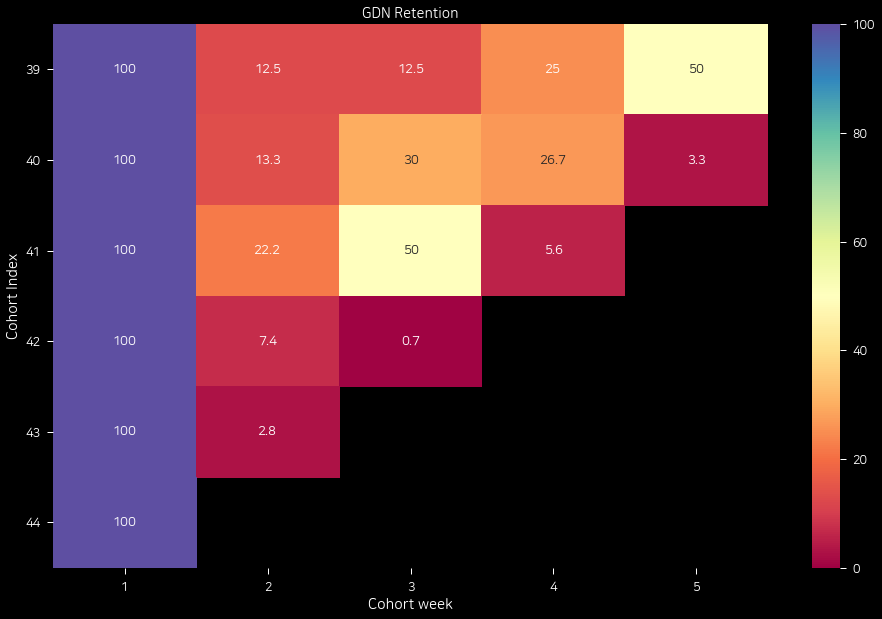

11.639999999999999

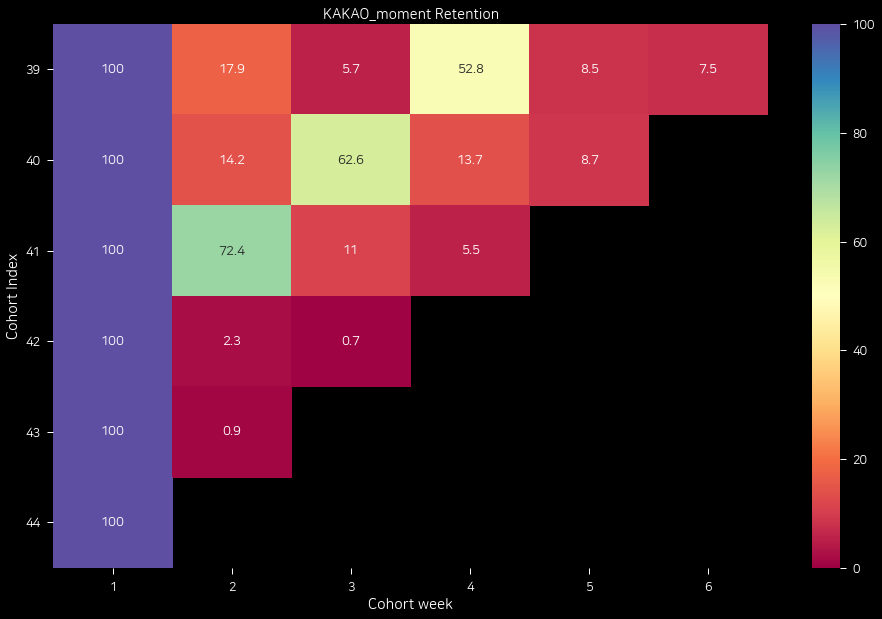

21.54

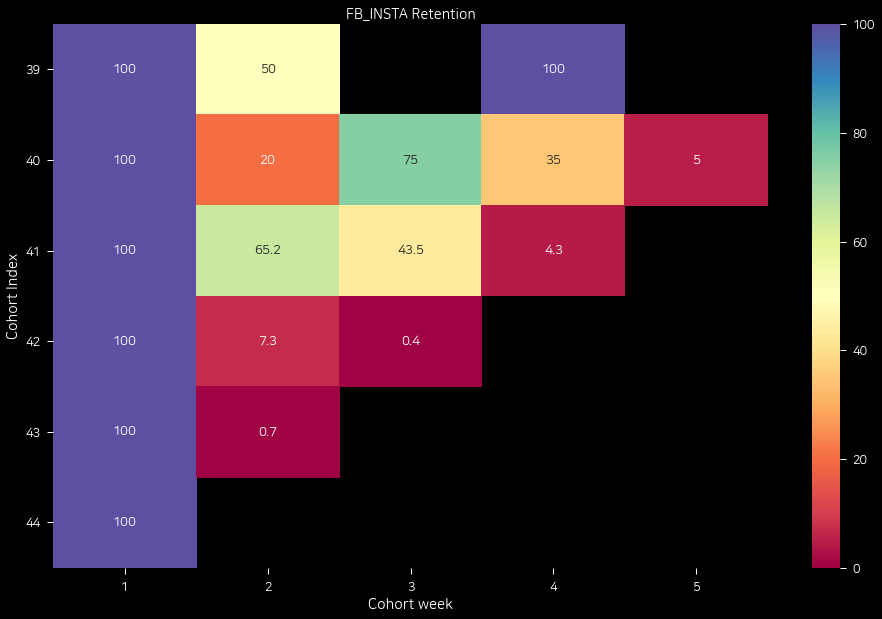

28.639999999999997

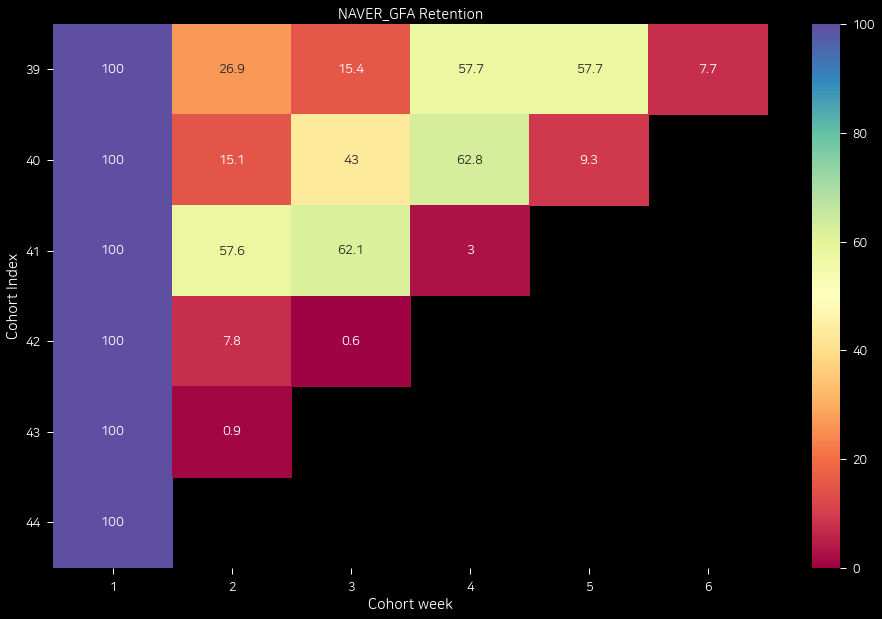

21.66

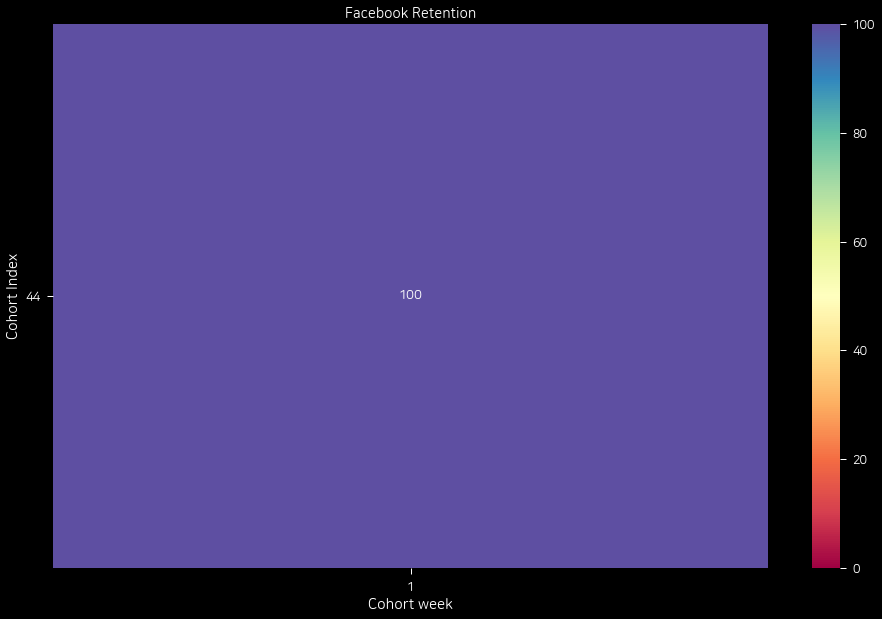

KeyError: 2

In [37]:
# #########################################
# # 2. 주차별 재방문율
# #########################################
# ## 1) 전체 주차별 재방문율
# df_retention = SphereRetention.retention_main(
#     df_app_log, KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = 'Total Retention')

## 2) 매체별 주차별 재방문율
for key, values in dict_lst_user_from_referrs_gudok.items():
    df_retention = SphereRetention.retention_main(
        df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)], 
        KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = f'{key} Retention')

    df_retention[2].mean()

### (3)구독전환
- 구독전환수
- 구독전환율

In [36]:
#########################################
# 1. 구독완료
#########################################
## 1) 일별 구독완료 유저 수
dict_subscribe = {}

df_daily_subscribe = pd.DataFrame()
df_daily_subscribe = get_daily_cnt(dict_output=dict_subscribe, lst=lst_total_device, nm='subscribe_cnt', dict_input = dict_lst_user_from_referrs_gudok,
                    make_sub_dict = True)
df_daily_subscribe

,total_subscribe_cnt,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,
2022-10-01,118057,4,64,2.0,12,117595
2022-10-02,104588,4,46,2.0,14,104196
2022-10-03,75489,6,31,2.0,9,75090
2022-10-04,71652,5,50,4.0,13,71203
2022-10-05,69234,2,180,7.0,5,68616
2022-10-06,59372,2,55,0.0,13,58907
2022-10-07,85988,6,59,3.0,19,85287
2022-10-08,136494,6,37,3.0,24,135947
2022-10-09,76787,8,23,4.0,16,76338


In [38]:
#########################################
# 2. 구독전환율
#########################################
## 매체별 전환율
### 랜딩페이지 > 구독
df_subscribe_conversion = pd.DataFrame(
                            index=[
                                'landing_cnt', 
                                'subscribe_cnt', 
                                'subscribe_conversion'])

for key, df in dict_df_param_contents.items():
    _df = df[df[PARAM_CONTENT_NAME] == '가볼래-터 구독하러 가기']
    LANDING_CNT = _df[KEY_ID_DEVICE].nunique()

    _df = df_param_subscribe[
                        df_param_subscribe[KEY_ID_DEVICE].isin(
                            list(_df[KEY_ID_DEVICE])
                        )]
    SUBSCRIBE_CNT = _df[KEY_ID_DEVICE].nunique()
    dict_subscribe[f'{key}']['subscribe_conversion'] = [LANDING_CNT,
                                                    SUBSCRIBE_CNT, 
                                                    (SUBSCRIBE_CNT/LANDING_CNT)]

    df_subscribe_conversion[f'{key}'] =\
        dict_subscribe[f'{key}']['subscribe_conversion']

df_subscribe_conversion

,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
landing_cnt,12341.000000,8856.00000,8384.000000,11471.00000,31718.000000
subscribe_cnt,6.000000,55.00000,119.000000,46.00000,1901.000000
subscribe_conversion,0.000486,0.00621,0.014194,0.00401,0.059934


### (4)Fraud
- 바운스율
- 정착율

In [14]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율
#########################################
dict_fraud_referrs = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)]
    _df = _df.groupby(KEY_ID_DEVICE)['duration'].sum().reset_index()
    lst_device_fraud = list(_df[KEY_ID_DEVICE][_df['duration'] < 5].unique())

    TOTAL_CNT = _df[KEY_ID_DEVICE].nunique()
    FRAUD_CNT = len(lst_device_fraud)
    FRAUD_RATE = FRAUD_CNT / TOTAL_CNT
    # SETTLE_RATE = 1 - FRAUD_RATE                                

    dict_fraud_referrs[f'{key}'] = [TOTAL_CNT, FRAUD_CNT, FRAUD_RATE,  1 - FRAUD_RATE]

df_fraud_referrs = pd.DataFrame.from_dict(
    dict_fraud_referrs, orient='index', columns=[
        'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])

df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
GDN,12381,9949,0.803570,0.196430
KAKAO_moment,12621,7363,0.583393,0.416607
FB_INSTA,8388,7120,0.848832,0.151168
NAVER_GFA,11473,10180,0.887301,0.112699
organic,2075941,1510853,0.727792,0.272208


### (5)앱설치 유저

In [15]:
# #########################################
# # 0. prep
# #########################################
df_id_prep = SpherePrep.Prop.df_prop_pipe(
                df_app_log, [KEY_ID_DEVICE, KEY_ID_USER], 
                drop_none_prop = False)

#########################################
# 1. 앱설치 유저
#########################################
dict_install = {}
df_install_cnt = pd.DataFrame()
_df_log_target = df_app_log[df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)]

for key, lst in dict_lst_user_from_referrs_gudok.items():
    _lst = list(set(df_id_prep[KEY_ID_DEVICE][df_id_prep[KEY_ID_DEVICE].isin(lst)]))
    
    dict_install[f'{key}'] = {}
    dict_install[f'{key}']['device_id'] =\
        _df_log_target[KEY_ID_DEVICE][_df_log_target[KEY_ID_DEVICE].isin(_lst)]

    dict_install[f'{key}']['cnt'] = len(dict_install[f'{key}']['device_id'])
    df_install_cnt[f'{key}_cnt'] = dict_install[f'{key}']['cnt']

    print(f'{key}: ', dict_install[f'{key}']['cnt'])

GDN:  0
KAKAO_moment:  0
FB_INSTA:  0
NAVER_GFA:  0
organic:  31371


In [16]:
# # 2. gender & age_group 
# ## KAKAO_moment: drop (설치자 0명이라서)
# dict_lst_user_from_referrs_gudok_demo = dict_lst_user_from_referrs_gudok
# del dict_lst_user_from_referrs_gudok_demo['KAKAO_moment']

# ## 시각화
# Profiling.demo_profiling( 
#     df_user_prop=df_prop, KEY_ID=KEY_ID_DEVICE, 
#     dict_user_list=dict_lst_user_from_referrs_gudok_demo, 
#     total_avg = True, vis_type = 'all')

In [45]:
# ## exact numbers age/gender by referrs
# _df_gender = pd.DataFrame()
# _df_age = pd.DataFrame()

# for key, lst_id in dict_lst_user_from_referrs_gudok_demo.items():
#     if key != 'total':
#         _df = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_id)]
#         _df_gender = pd.concat(
#             [_df_gender, _df['gender'].value_counts().to_frame(name = f'{key}_gender')], axis=1).fillna(0)
#         _df_age = pd.concat(
#             [_df_age, _df['age_group'].value_counts().to_frame(name = f'{key}_age')], axis=1).fillna(0)
#     else:
#         pass

# _df_gender
# _df_age

### (6)활성
- 인당 체류 시간
- 인당 컨텐츠 조회수
- 검색 조회 빈도

In [17]:
#########################################
# 1. 인당 체류시간
#########################################
lst_device_no_fraud = list(set(lst_total_device) - set(lst_device_fraud))
_df_log_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

dict_duration = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target[_df_log_target[KEY_ID_DEVICE].isin(values)]

    dict_duration[f'{key}'] = {}
    dict_duration[f'{key}']['duration'] = _df.groupby(
                        KEY_ID_DEVICE)['duration'].sum().to_frame(
                            name = 'total_duration')

    print(f'{key} 인당 평균 체류시간: ', dict_duration[f'{key}']['duration']['total_duration'].mean(), '초')

GDN 인당 평균 체류시간:  78.24260567593791 초
KAKAO_moment 인당 평균 체류시간:  115.46963100627431 초
FB_INSTA 인당 평균 체류시간:  20.18954196556672 초
NAVER_GFA 인당 평균 체류시간:  33.69010838914346 초
organic 인당 평균 체류시간:  280.31276998272824 초


In [18]:
#########################################
# 2. 인당 컨텐츠 조회수
#########################################
## 1) 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
### (1) 이상 유저 제거 x

#### 이벤트 및 랜딩 페이지 접속 유저 id 리스트 생성
lst_landing_device = df_param_contents[KEY_ID_DEVICE][
    df_param_contents[PARAM_CONTENT_NAME]=='가볼래-터 구독하러 가기']

lst_event_letter = ['balanceGameMain', 'balanceGame', 'travelLetterDetail', 'travelLetterLike', 'travelLetterNotLike']

#### prep
_df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

_df_log_target = _df_log_target_letter[
    _df_log_target_letter['abs_events'].apply(lambda x : True
                                    if len(set(lst_event_letter) & set(x)) > 0 else False)]

#### calculate event cnt
print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 포함)')
cal_event_cnt_per_device_ver1(
        _df_log_target, dict_lst_user_from_referrs_gudok, 
        lst_event_letter, '인당 일별 평균 컨텐츠 조회수: ')

print('-'*50)
print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 제거)')

### (2) 이상 유저 제거 o
#### prep
_df_log_target_no_fraud = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

_df_log_target = _df_log_target_no_fraud[
    _df_log_target_no_fraud['abs_events'].apply(lambda x : True
                                    if len(set(lst_event_letter) & set(x)) > 0 else False)]

#### calculate event cnt
cal_event_cnt_per_device_ver1(
        _df_log_target_no_fraud, dict_lst_user_from_referrs_gudok, 
        lst_event_letter,'인당 일별 평균 컨텐츠 조회수: ')


#############################################################################################################


## 2) 전체 컨텐츠 인당 일별 조회 수
### 2-1) 랜딩 페이지 접속 유저

#### 이상 유저 제거 x
print('-'*50)
print('인당 전체 컨텐츠 조회수')
cal_event_cnt_per_device_ver2(_df_log_target_letter,
        '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


#### 이상 유저 제거 o
cal_event_cnt_per_device_ver2(_df_log_target_no_fraud,
        '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')


### 2-2) 랜딩 페이지 접속 x 유저
#### 이상 유저 제거 x
lst_not_landing_device = set(lst_total_device) - set(lst_landing_device)
_df_log_target2 = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_not_landing_device)]
cal_event_cnt_per_device_ver2(_df_log_target2,
        '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


#### 이상 유저 제거 o
_df_log_target_no_fraud2 =\
        _df_log_target2[_df_log_target2[KEY_ID_DEVICE].isin(lst_device_no_fraud)]
cal_event_cnt_per_device_ver2(_df_log_target_no_fraud2,
        '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')

인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 포함)
GDN 인당 일별 평균 컨텐츠 조회수:  1.0 회
KAKAO_moment 인당 일별 평균 컨텐츠 조회수:  1.78 회
FB_INSTA 인당 일별 평균 컨텐츠 조회수:  1.05 회
NAVER_GFA 인당 일별 평균 컨텐츠 조회수:  1.07 회
organic 인당 일별 평균 컨텐츠 조회수:  1.58 회
--------------------------------------------------
인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 제거)
GDN 인당 일별 평균 컨텐츠 조회수:  1.07 회
KAKAO_moment 인당 일별 평균 컨텐츠 조회수:  1.44 회
FB_INSTA 인당 일별 평균 컨텐츠 조회수:  1.04 회
NAVER_GFA 인당 일별 평균 컨텐츠 조회수:  1.06 회
organic 인당 일별 평균 컨텐츠 조회수:  3.79 회
--------------------------------------------------
인당 전체 컨텐츠 조회수
랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함):  2.58 회
랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거):  2.59 회
랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함):  1.21 회
랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거):  1.62 회


In [19]:
#########################################
# 2. 인당 컨텐츠 조회수
#########################################
## 1) 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
### ---> 이상 유저 제거 후 값이 감소한 케이스에 대해 이상유저의 페이지 조회 수 확인
_df = _df_log_target_no_fraud[
        ['abs_events', 'event_cnt', 'referrer_utm_source']]\
                [_df_log_target_no_fraud[KEY_ID_DEVICE].isin(lst_fraud_device)]

_df_target_naver = _df[_df['referrer_utm_source'] == 'NAVER_GFA']
_df_target_insta = _df[_df['referrer_utm_source'] == 'FB_INSTA']

print('referrer_utm_source:  NAVER_GFA')
_df_target_naver['event_cnt'].value_counts()
print('referrer_utm_source:  FB_INSTA')
_df_target_insta['event_cnt'].value_counts()

referrer_utm_source:  NAVER_GFA


1      11484
2        420
3        170
4         32
6         14
5         14
8         11
7          7
9          7
10         5
11         5
23         5
28         4
18         4
27         4
12         4
31         3
13         3
15         3
36         2
19         2
30         2
25         2
26         2
14         2
59         2
69         1
16         1
24         1
40         1
64         1
21         1
99         1
17         1
29         1
37         1
73         1
81         1
22         1
20         1
133        1
35         1
34         1
85         1
49         1
Name: event_cnt, dtype: int64

referrer_utm_source:  FB_INSTA


1     7909
2      215
3       63
4       25
5       20
6       15
8        8
7        7
9        7
11       6
10       4
18       4
22       3
12       3
15       3
16       3
13       2
53       2
20       2
27       2
24       1
32       1
40       1
56       1
31       1
17       1
19       1
28       1
60       1
21       1
37       1
30       1
43       1
Name: event_cnt, dtype: int64

In [20]:
#########################################
# 3. 인당 검색 조회 빈도
#########################################
## 1) 랜딩페이지 접속 유저
### 이상 유저 포함
_df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

dict_search = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(values)]
    _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
    dict_search[f'{key}_이상 유저 포함'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
    print(f'{key} 인당 검색 조회 빈도(이상 유저 포함): ', round(dict_search[f'{key}_이상 유저 포함'], 2), '회')

print('-'*50)

### 이상 유저 제거
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target_no_fraud[_df_log_target_no_fraud[KEY_ID_DEVICE].isin(values)]
    _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
    dict_search[f'{key}_이상 유저 제거'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
    print(f'{key} 인당 검색 조회 빈도(이상 유저 제거): ', round(dict_search[f'{key}_이상 유저 제거'] , 2), '회')

GDN 인당 검색 조회 빈도(이상 유저 포함):  1.07 회
KAKAO_moment 인당 검색 조회 빈도(이상 유저 포함):  1.44 회
FB_INSTA 인당 검색 조회 빈도(이상 유저 포함):  1.05 회
NAVER_GFA 인당 검색 조회 빈도(이상 유저 포함):  1.05 회
organic 인당 검색 조회 빈도(이상 유저 포함):  3.75 회
--------------------------------------------------
GDN 인당 검색 조회 빈도(이상 유저 제거):  1.07 회
KAKAO_moment 인당 검색 조회 빈도(이상 유저 제거):  1.44 회
FB_INSTA 인당 검색 조회 빈도(이상 유저 제거):  1.04 회
NAVER_GFA 인당 검색 조회 빈도(이상 유저 제거):  1.06 회
organic 인당 검색 조회 빈도(이상 유저 제거):  3.79 회


## 2)이동경로
- 광고 유입
    - 구독 완료자 이동 경로
    - 구독 미완료자 이동 경로

- 자연 유입
    - 구독 완료자 이동 경로
    - 구독 미완료자 이동 경로
    - 도착 지점 도착 유저 이동 경로
    - 도착 지점 미도착 유저 이동 경로

In [9]:
## 1) 가볼래터 캠페인 참가자의 데이터 생성
### (1) 참가 device
lst_campaign_device = list(df_app_log[df_app_log['referrer_utm_campaign'] == '2022_gudok'][KEY_ID_DEVICE].unique())
lst_campaign_subscribe_o = list(set(lst_campaign_device) & set(lst_subscribe_device))
lst_campaign_subscribe_x = list(set(lst_campaign_device) - set(lst_campaign_subscribe_o))

In [86]:
# for _lst_target in [lst_campaign_subscribe_x, lst_campaign_subscribe_o] :
lst_target = lst_campaign_subscribe_o
### (2) session data frame
_, df_param_campagin_session = DataImport.json_to_dataframe_nodeN( 
    df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_target)], 
    [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
    ) ### + param by session
df_param_campagin_session['date'] = pd.to_datetime(df_param_campagin_session['date'], format='%Y%m%d %H:%M:%S')
df_param_campagin_session['date_hm'] = df_param_campagin_session['date'].apply(lambda x : x.strftime('%y-%m-%d %H:%M'))

### 2) 가볼래터 이벤트명 변경 data 생성
df_param_contents_letter =\
     df_param_campagin_session[
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)) | 
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False))
        ]
### 구독 이벤트명 변경
df_param_contents_letter['name'] =  df_param_contents_letter[PARAM_CONTENT_NAME]

df_param_contents_except_letter =\
     df_param_campagin_session[
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False) ) &
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False) )
        ]

df_param_campagin_session_letter = pd.concat([
    df_param_contents_letter,
    df_param_contents_except_letter
])

df_param_campagin_session_letter = df_param_campagin_session_letter.sort_values(by = ['sid', 'date'])
df_param_campagin_session_letter = df_param_campagin_session_letter.drop_duplicates(['sid', 'date_hm', 'name'], keep='first') # 동일 분 안에 중복 이벤트 제거

In [87]:
# make sequance data
dict_journey_subset_to_kpi = {}
dict_journey_subset_after_kpi = {}

for _key_id in df_param_campagin_session_letter[KEY_ID_DEVICE].unique()[:5] : 
    _df_journey_subset = df_param_campagin_session_letter[df_param_campagin_session_letter[KEY_ID_DEVICE] == _key_id].reset_index(drop = True)
    if '구독신청 완료!' in _df_journey_subset[PARAM_CONTENT_NAME].unique() :
        kpi_index = _df_journey_subset[_df_journey_subset[PARAM_CONTENT_NAME] == '구독신청 완료!'].index[0]
        _df_journey_subset_to_kpi = _df_journey_subset.iloc[:kpi_index+1]
        _df_journey_subset_after_kpi = _df_journey_subset.iloc[kpi_index+1:]
        _dict_journey_subset_to_kpi = _df_journey_subset_to_kpi[['name']].T.to_dict(orient = 'records')[0]
        _dict_journey_subset_after_kpi = _df_journey_subset_after_kpi[['name']].T.to_dict(orient = 'records')[0]
        
        for i, _event in _dict_journey_subset_to_kpi.items() :
            if i not in dict_journey_subset_to_kpi.keys() :
                dict_journey_subset_to_kpi[i] = [_event]
            else :
                dict_journey_subset_to_kpi[i] = dict_journey_subset_to_kpi[i] + [_event]


In [85]:
from collections import Counter
Counter(dict_journey_subset_to_kpi[0])


Counter({'가볼래-터 구독하러 가기': 4, 'balanceGameMain': 1})

In [26]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 가볼래터 한정 contentdetail -> contentletter로 데이터 값 정정 ------------> 코드 수정 필요
df_param_contents_letter['name'] = df_param_contents_letter['name'].apply(
    lambda x : 'sapContentDetail' if x == 'sapContentDetail' else x)\
        .replace({'sapContentDetail':'sapContentLetterDetail'})

## 두 df 차집합 구하고 한 테이블로 셋팅
_df_diff = pd.concat([df_param_all_session, df_param_contents_letter, df_param_contents_letter]).drop_duplicates(keep=False)
df_param_all_prep = pd.concat([_df_diff, df_param_contents_letter], axis = 0).drop_duplicates(keep='first')

## 세그먼트 데이터 생성
df_param_all_referrs = df_param_all_prep[df_param_all_prep[KEY_ID_DEVICE].isin(lst_landing_device)]
df_param_all_referrs.sort_values(by = 'date').groupby([KEY_ID_DEVICE, 'sid', 'day']).head()

,uid,user_id,sid,name,date,params_sapContentId,params_sapContentCat1Id,params_sapContentCat1Name,params_sapContentFilter1,params_sapContentFilter2,...,params_qrStoreCode,params_sapContentFilter3,params_promotionCat2Name,params_couponName,params_courseName,params_subContentId,params_subContentName,params_contentName,params_contentSize,day
4827425,FO_omq6YQhi5GmKtN9IBCg,,-j37dDVqTMil40cCc1iNiA,sapHome,2022-08-17 11:16:03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-17
7388180,p7jDIO-4RBaN_p5Vq32LBw,,MMuD3ZA8ThChpmPB5cJWqA,sapHome,2022-08-19 21:08:38,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-19
6402994,0PK8TL4IQQipm8Rd9QZp1g,,jwDYPWXrQdmB7h_LsypiPA,searchMain,2022-08-20 12:18:23,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-20
1773579,7XY0rUQ0SVmOY3hwqlnTsA,,GkYefXIeT2C-wdlL8lbZAQ,sapHome,2022-08-22 13:17:15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22
2190513,kFXpjgU1TBu2E3kizBzTMg,,gCAT4ig1QCuPJeRqTpkQVg,sapContentDetail,2022-08-23 11:03:29,1a1a148e-2776-4304-9154-92136ec54ad2,event,이벤트,212,650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531367,FCYCmpFDqSdLRoX0hImD-A,acc7fa78-decb-46d0-84fb-3141d157d9a5,yTriRIrkM4V_L5rjWp4gfh,searchMain,2022-11-02 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-02
7531368,FCYCmpFDqSdLRoX0hImD-A,acc7fa78-decb-46d0-84fb-3141d157d9a5,yTriRIrkM4V_L5rjWp4gfh,searchMain,2022-11-02 00:00:04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-02
7531369,FCYCmpFDqSdLRoX0hImD-A,acc7fa78-decb-46d0-84fb-3141d157d9a5,yTriRIrkM4V_L5rjWp4gfh,searchMain,2022-11-02 00:00:05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-02
7531370,FCYCmpFDqSdLRoX0hImD-A,acc7fa78-decb-46d0-84fb-3141d157d9a5,yTriRIrkM4V_L5rjWp4gfh,searchMain,2022-11-02 00:00:12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-02


In [27]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 10월 이전 데이터 확인
df_param_all_referrs[df_param_all_referrs['date'] < '2022-10-01 00:00:00'].shape[0]
print('-'*70)

## 10월 이전 데이터 제거
df_param_all_referrs =\
    df_param_all_referrs[
        df_param_all_referrs['date'] >=\
             '2022-10-01 00:00:00']
df_param_all_referrs.head(3)

(70, 59)

----------------------------------------------------------------------


,uid,user_id,sid,name,date,params_sapContentId,params_sapContentCat1Id,params_sapContentCat1Name,params_sapContentFilter1,params_sapContentFilter2,...,params_qrStoreCode,params_sapContentFilter3,params_promotionCat2Name,params_couponName,params_courseName,params_subContentId,params_subContentName,params_contentName,params_contentSize,day
62,tb070nxXTZ-wPiFtLJijdA,,kuFlRm8_Q6id0nKbslX63A,homeSearch,2022-10-01 00:00:28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-01
76,tb070nxXTZ-wPiFtLJijdA,,kuFlRm8_Q6id0nKbslX63A,homeSearch,2022-10-01 00:00:51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-01
106,T_AaqOZNQKO4EGSUG0bx0g,,xHthaVW2TaqFlPUSKeK5Gw,sapHome,2022-10-01 00:00:49,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-01


In [40]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 전처리를 위한 구분자 추가
df_param_all_referrs['name'] = \
     df_param_all_referrs['name'].apply(lambda x : x + '-')

df_user_referrs_event = \
    df_param_all_referrs.groupby('sid')['name'].sum()\
    .to_frame(name = 'event_name').reset_index()

df_user_referrs_event
print('-'*70)

## target user 그룹 생성
dict_end_ox_referrs = {}
_lst = []

for i in range(len(df_user_referrs_event)):
    if 'subscribe-' in df_user_referrs_event.iloc[i]['event_name']:
        _lst.append(df_user_referrs_event.iloc[i]['sid'])

dict_end_ox_referrs['subscribe'] = {}
dict_end_ox_referrs['subscribe']['sid']= list(set(_lst))

## target user의 가장 흔한 이동 경로
_df_target_journey =\
    df_user_referrs_event[
        df_user_referrs_event['sid'].isin(dict_end_ox_referrs['subscribe']['sid'])]

_df_target_journey2 = _df_target_journey.copy()             # 백업용 데이터 생성

## 구분자 -로 event_name 값 리스트 형태로 정정
for i in range(len(_df_target_journey)):
    _df_target_journey2.iloc[i]['event_name'] = _df_target_journey.iloc[i]['event_name'].split('-')

## 경로가 몇 번 겹치는지 확인
_df_cnt = _df_target_journey2['event_name'].value_counts().to_frame(name = 'cnt').reset_index()
_df_cnt['cnt'].value_counts()

1    2051
2      14
3       4
7       2
4       1
Name: cnt, dtype: int64

In [36]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## value_counts == 1인 경로 간 유사도 구하기
_df_cnt_1 = _df_cnt[_df_cnt['cnt'] == 1].reset_index(drop=True)
_lst_remove_index = []
_lst_target=list(_df_cnt_1['index'].unique())

i=0
while i < len(_df_cnt_1):
    x = i+1
    while x < len(_df_cnt_1):
        answer_string = _df_cnt_1.iloc[i]['index']
        input_string = _df_cnt_1.iloc[x]['index']

        intersection_cardinality = len(set.intersection(*[set(answer_string), set(input_string)]))
        union_cardinality = len(set.union(*[set(answer_string), set(input_string)]))
        similar = intersection_cardinality / float(union_cardinality)

        if similar > 0.3:
            _lst_remove_index.extend([i])        
            _lst_target = list(set(_lst_target) - set(answer_string))
        else:
            pass
        
        x+=1
    i+=1

_lst_remove_index = list(set(_lst_remove_index))
print('이동 경로 수: ',len(_lst_target))            ## 임계점이 0.5일 때 각기 다른 이동 경로 수가 2051개로 나옴 = 즉 유사도가 필터링해낸 경로(=같다고 본 경로)가 하나도 없다는 뜻 -> 따라서 임계점을 0.3으로 두고 진행해봄

,sid,event_name
0,--8HJ3jSENV6D87DPRzsRK,"[sapHome, themeTravelMain, searchMain, searchM..."
1,-21cOeXKR1aspVGxdItgEA,"[sapHome, searchMain, sapContentDetail, subscr..."
2,-4hcwfOeXAxEh_zHuJrjT8,"[sapContentDetail, sapContentDetail, sapConten..."
3,-6kkHjiB0sRsOCyQ8u2LGZ,"[sapHome, searchMain, searchMain, searchMain, ..."
4,-7ZLP100rrTrx0qotcnHQB,"[sapLogin, sapContentDetail, sapLogout, sapCon..."
...,...,...
2104,zpFmOXYsT-KDy8peBGfqSQ,"[sapHome, searchMain, balanceGameMain, balance..."
2105,zpsAV3544dZBLdQ8RPGeS0,"[sapHome, searchMain, searchMain, searchMain, ..."
2106,zq5T6GD2xfSiDZvWCNaGJO,"[sapHome, themeTravelMain, searchMain, searchM..."
2107,zuBMOwS90zacMbMVqUlcam,"[sapContentDetail, sapContentDetail, sapConten..."


이동 경로 수:  2051


In [ ]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
##
